# IMPORTANDO LIBRERIAS

In [1]:
import pandas as pd
import numpy as np
import cmath
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import welch
from scipy import signal

# FUNCIONES

## LECTURA DE DATOS

In [2]:
# FILTRO PASA ALTA
def butter_highpass(cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=2):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# LECTURA DE DATOS DE UNA CARPETA
def read_data_semg(PATH):
    sensor_01 = np.loadtxt(PATH+'/sensor_1_1.txt')
    sensor_02 = np.loadtxt(PATH+'/sensor_2_1.txt')
    sensor_01 = butter_highpass_filter(sensor_01, 20, 1000)
    sensor_02 = butter_highpass_filter(sensor_02, 20, 1000)
    sensor_01 = sensor_01.reshape(1,len(sensor_01))
    sensor_02 = sensor_02.reshape(1,len(sensor_02))
    for i in range(9):
        # Cargando la data
        path_sensor_1 = '/sensor_1_'+str(i+2)+'.txt'
        path_sensor_2 = '/sensor_2_'+str(i+2)+'.txt'
        data_sensor_1 = np.loadtxt(PATH+path_sensor_1)
        data_sensor_2 = np.loadtxt(PATH+path_sensor_2)
        # Aplicando filtro
        data_sensor_1 = butter_highpass_filter(data_sensor_1, 20, 1000)
        data_sensor_2 = butter_highpass_filter(data_sensor_2, 20, 1000)      
        # Redimensionando la data a (8000,1)
        data_sensor_1 = data_sensor_1.reshape(1,len(data_sensor_1))
        data_sensor_2 = data_sensor_2.reshape(1,len(data_sensor_2))
        # Acumulando la data
        sensor_01 = np.concatenate([sensor_01,data_sensor_1],axis=0)
        sensor_02 = np.concatenate([sensor_02,data_sensor_2],axis=0)
    return sensor_01, sensor_02

## FUNCIONES DE SUAVIZADO Y TRANSFORMADA DE LA SEÑAL

In [3]:
# SUAVIZADO DE LA SEÑAL
def moving_average(NumTimePeriod,offset,data):
    mylist = abs(data)
    N = NumTimePeriod
    cumsum, moving_aves = [0], []
    
    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        if (((i-N)>=0) & ((i-N)%offset==0)):
            div = int((i-N)/offset)
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return moving_aves

def get_psd_values(y_values, t_n, N):
    T = t_n / N # Periodo de muestreo
    f_s = 1/T # Frecuencia de muestreo
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def generate_ma_data(data, NumPeriod, Overlap):
    data_ma_list = []
    for serie in data:
        data_ma_list.append(moving_average(NumPeriod,Overlap,serie))
    return data_ma_list

def generate_psd_data(data,t_n,N):
    data_psd_list = []
    data_f_list = []
    for serie in data:
        f_values, psd_values = get_psd_values(serie,t_n,N)
        data_psd_list.append(psd_values)
        data_f_list.append(f_values)
    data_psd_total = [data_f_list, data_psd_list]
    return data_psd_total

# LECTURA DE DATOS

In [4]:
PATH = r'/home/liiaarc/Desktop/Armband/Armband_matlab_files/Data/Data_6_12/Captura1'

In [5]:
sensor_01, sensor_02 = read_data_semg(PATH)

In [6]:
# POWER SPECTRUM DENSITY
psd_sensor_01 = generate_psd_data(sensor_01,8,8000)
psd_sensor_02 = generate_psd_data(sensor_02,8,8000)

In [7]:
# MOVING AVERAGE DATA
ma_sensor_01 = generate_ma_data(sensor_01, 50, 25)
ma_sensor_02 = generate_ma_data(sensor_02, 50, 25)

# GRÁFICO DE SEÑALES

In [8]:
def plot_all_signals(data_semg1,data_semg2,tipo,xlab):
    fig, axes = plt.subplots(10,2, figsize = (15,20))
    for i in range(10):
        title1 = 'R'+str(i+1)+' '+tipo + ' sEMG 01'
        title2 = 'R'+str(i+1)+' '+tipo + ' sEMG 02'
        axes[i][0].plot(data_semg1[i],'b');
        axes[i][0].set_title(title1);
        axes[i][0].set_xlabel(xlab);
    
        axes[i][1].plot(data_semg2[i],'g');
        axes[i][1].set_title(title2);
        axes[i][1].set_xlabel(xlab);
    plt.subplots_adjust(hspace=1, wspace=0.15)
# Tipo: Señal, MA, PSD

def plot_psd_signals(data_semg1,data_semg2,tipo):
    fig, axes = plt.subplots(10,2, figsize = (15,20))
    for i in range(10):
        title1 = 'R'+str(i+1)+' '+tipo + ' sEMG 01'
        title2 = 'R'+str(i+1)+' '+tipo + ' sEMG 02'
        axes[i][0].plot(data_semg1[0][i],data_semg1[1][i],'b');
        axes[i][0].set_title(title1);
        axes[i][0].set_xlabel('Frequency [Hz]');
        axes[i][0].set_ylabel('PSD [mV**2 / Hz]')
    
        axes[i][1].plot(data_semg2[0][i],data_semg2[1][i],'g');
        axes[i][1].set_title(title2);
        axes[i][1].set_xlabel('Frequency [Hz]');
        axes[i][1].set_ylabel('PSD [mV**2 / Hz]')
    plt.subplots_adjust(hspace=1, wspace=0.15)

## SEÑAL SIN PROCESAR

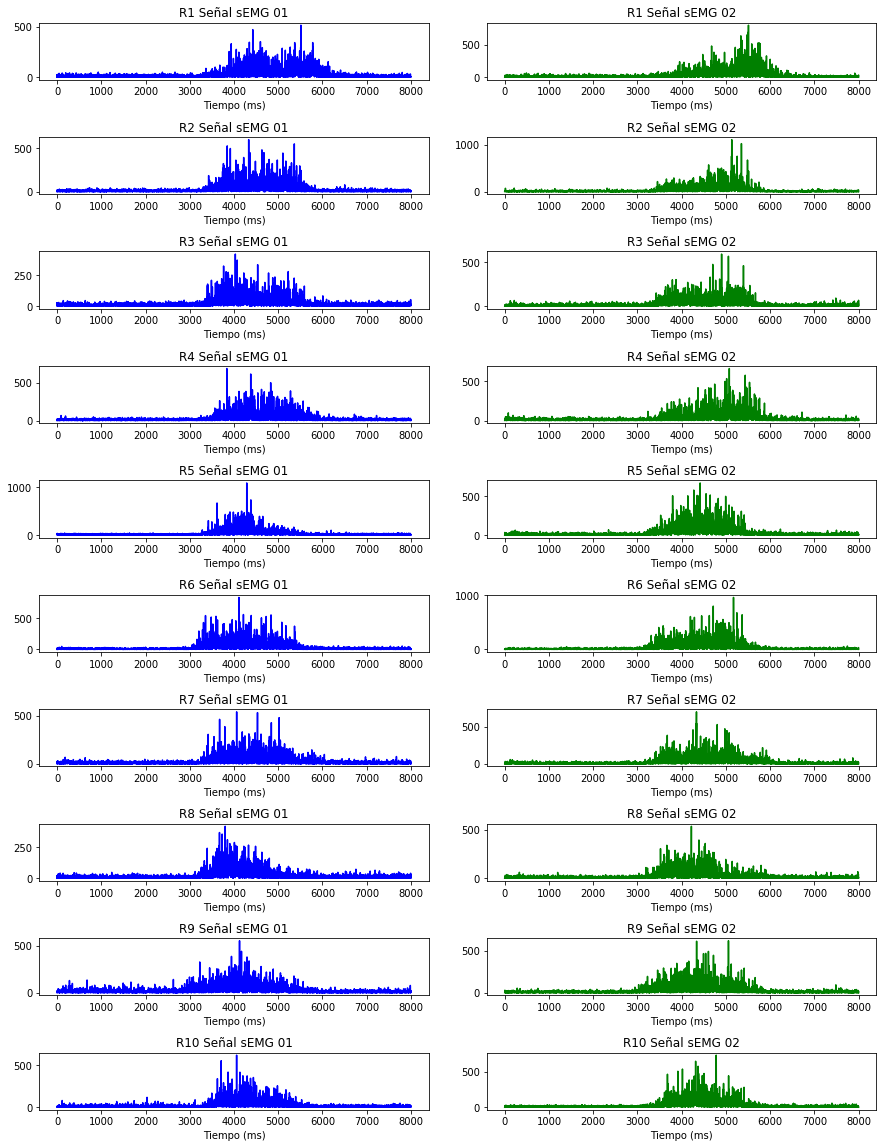

In [9]:
plot_all_signals(abs(sensor_01),abs(sensor_02),tipo = 'Señal',xlab = 'Tiempo (ms)')

## SEÑAL SUAVIZADA (MOVING AVERAGE)

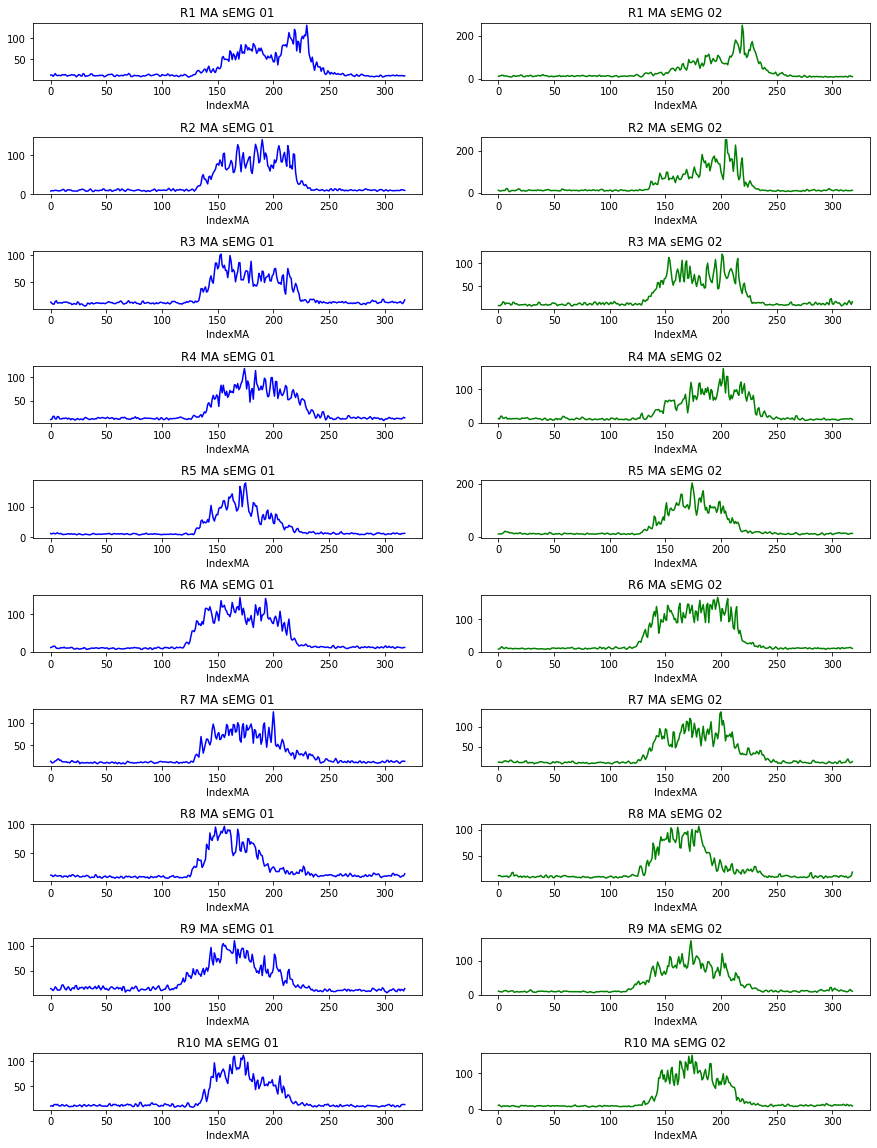

In [10]:
plot_all_signals(ma_sensor_01,ma_sensor_02,tipo = 'MA',xlab = 'IndexMA')

## DENSIDAD ESPECTRAL DE POTENCIA DE LA SEÑAL

Energía que hay dentro de una señal vibratoria

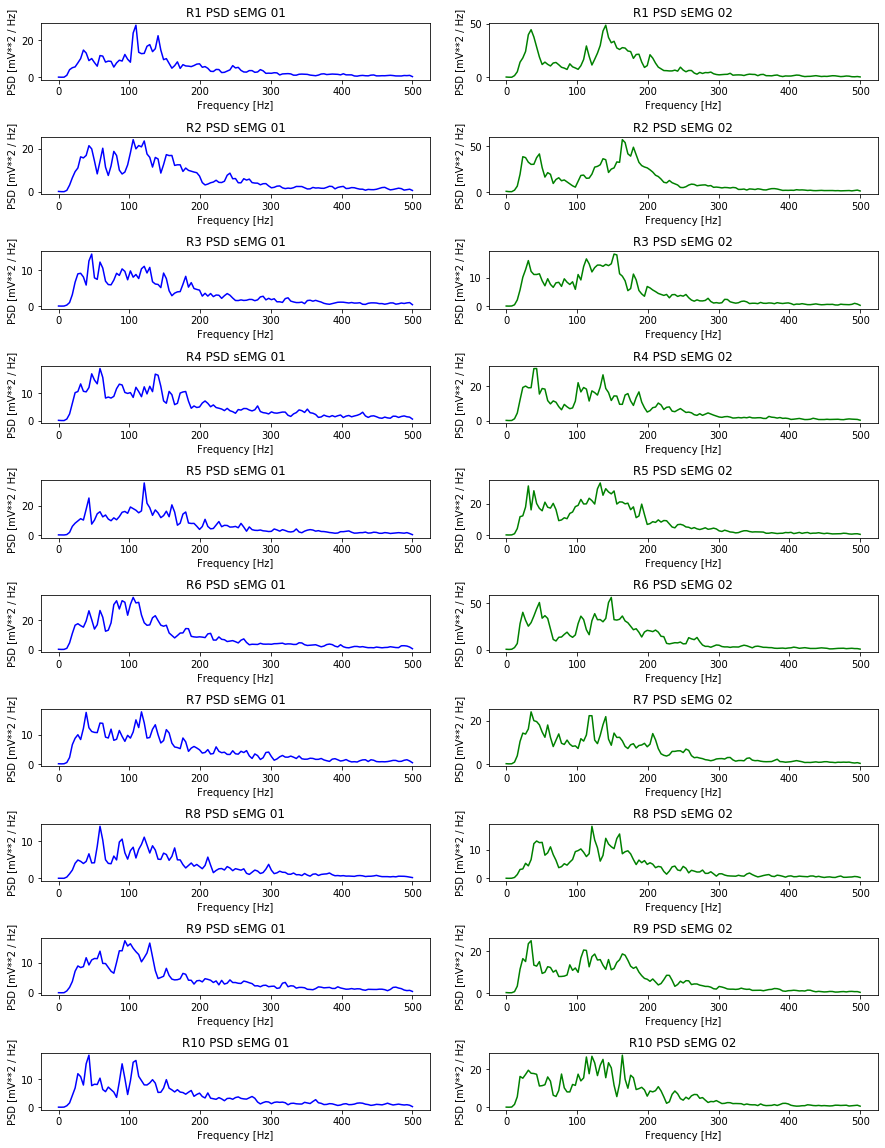

In [11]:
plot_psd_signals(psd_sensor_01,psd_sensor_02,'PSD')

# ANÁLISIS DE FATIGA

### APROXIMACIÓN 1 - ANÁLISIS EN UN CONJUNTO DE REPETICIONES
##### MEAN PSD


In [12]:
len(psd_sensor_01[0])

10

In [13]:
mean_psd_01 = np.mean(psd_sensor_01[1],axis =1)
mean_psd_02 = np.mean(psd_sensor_02[1],axis =1)

In [14]:
def linear_regression_line(data,N):
    x = np.array(range(N))+1
    coef = np.polyfit(x,data,1)
    result = coef[0]*x + coef[1]
    return result, coef[0]

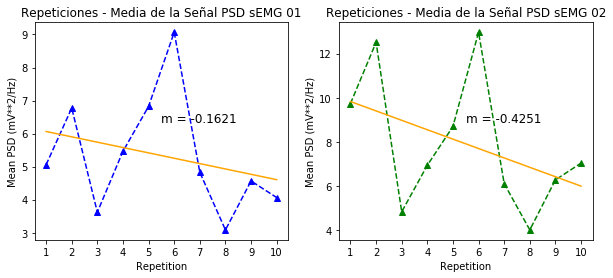

In [15]:
# Plot de la media de la densidad del espectro de potencia de las señales  
mean_data = [mean_psd_01, mean_psd_02]
fig, axes = plt.subplots(1,2, figsize = (10,4))
colors = ['b^--','g^--']
xlab = np.array(range(10))+1
pendientes = []
for j in range(2):
    title = 'Repeticiones - Media de la Señal PSD sEMG 0'+str(j+1)
    axes[j].plot(xlab,mean_data[j],colors[j]);
    y_reg, m_reg = linear_regression_line(mean_data[j],10)
    pendientes.append(m_reg)
    m_reg = "%.4f" % m_reg
    pendiente ='m = '+m_reg
    axes[j].plot(xlab,y_reg,'orange')
    axes[j].set_title(title);
    axes[j].set_title(title);
    axes[j].set_xlabel('Repetition');
    axes[j].set_ylabel('Mean PSD (mV**2/Hz)');
    axes[j].text(np.mean(xlab), np.mean(y_reg)+1, pendiente, fontsize=12)
    axes[j].set_xticks(ticks = xlab);

In [16]:
pendientes

[-0.16212012042284774, -0.425099958436625]

In [17]:
print('El indicador de fatiga utilizando Mean PSD es de: %.4f' % np.mean(pendientes))

El indicador de fatiga utilizando Mean PSD es de: -0.2936


### APROXIMACIÓN 2 - ANÁLISIS EN CADA REPETICIÒN 
##### MEAN FRECUENCY

In [18]:
data_sensor_01 = sensor_01[0]
data_sensor_02 = sensor_02[0]

In [19]:
def mean_freq_psd_calculator(psd_data_freq,psd_data_amp):
    freqs = psd_data_freq
    psd = psd_data_amp
    mean_freq = sum(freqs*psd)/sum(psd)    
    return mean_freq


def get_mean_psd_over_time_window(NumTimePeriod, offset, data, t_n, N_muestras):
    my_list = data
    N = NumTimePeriod
    mean_freq = []
    
    for i, x in enumerate(my_list, 1):
        if (((i-N)>=0) & ((i-N)%offset==0)):
            data_i = my_list[(i-N):i]
            freqs_i, amp_i = get_psd_values(data_i, t_n, N_muestras)
            mean_freq_i = mean_freq_psd_calculator(freqs_i,amp_i)
            mean_freq.append(mean_freq_i)
            
    return mean_freq            
            

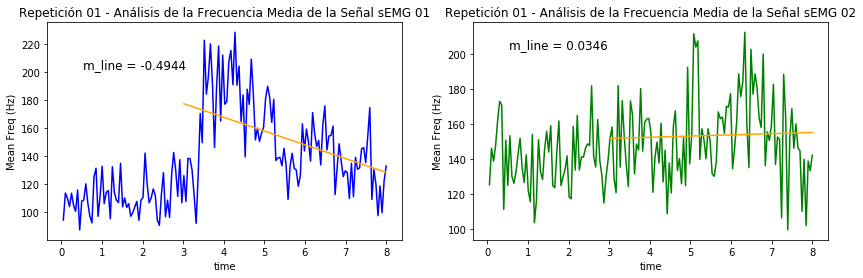

In [20]:
# Plot de la media de la densidad del espectro de potencia de las señales durante el ejercicio 
mean_freq = get_mean_psd_over_time_window(100,50,data_sensor_01, 8, 8000)
mean_freq_2 = get_mean_psd_over_time_window(100,50,data_sensor_02, 8, 8000)

mean_data = [mean_freq, mean_freq_2]
mean_data = np.array(mean_data)
fig, axes = plt.subplots(1,2, figsize = (14,4))

N = len(mean_data[0])
colors = ['b','g']
xlab = (np.array(range(N))+1)*(8/N)
start = int((3000/50)-1)
xline = (np.array(range(N-start))+1)*(8/N)+start*(8/N)
pendientes = []
for j in range(2):
    title = 'Repetición 01 - Análisis de la Frecuencia Media de la Señal sEMG 0'+str(j+1)
    axes[j].plot(xlab,mean_data[j],colors[j]);
    y_reg, m_reg = linear_regression_line(mean_data[j][start:N],(N-start))
    pendientes.append(m_reg)
    m_reg = "%.4f" % m_reg
    pendiente ='m_line = '+m_reg
    axes[j].plot(xline,y_reg,'orange')
    axes[j].set_title(title);
    axes[j].set_title(title);
    axes[j].set_xlabel('time');
    axes[j].set_ylabel('Mean Freq (Hz)');
    axes[j].text(np.mean(xline)-(start+40)*(8/N), np.mean(y_reg)+50, pendiente, fontsize=12)

In [21]:
pendientes

[-0.4944249222912411, 0.03462834867657017]

In [22]:
print('El indicador de fatiga utilizando Mean PSD overtime es de: %.4f' % np.mean(pendientes))

El indicador de fatiga utilizando Mean PSD overtime es de: -0.2299
